In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aitude_aptos_augmented_images_path = kagglehub.dataset_download('aitude/aptos-augmented-images')

print('Data source import complete.')


100%|██████████| 2.77G/2.77G [02:23<00:00, 20.7MB/s]

Extracting files...


Data source import complete.


In [2]:
import os
import random
import shutil
import hashlib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
source_path = "/root/.cache/kagglehub/datasets/aitude/aptos-augmented-images/versions/1/aptos-augmented-images"
destination_path = "/content/"

# Membuat folder tujuan jika belum ada
os.makedirs(destination_path, exist_ok=True)

# Menyalin dataset ke folder tujuan
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Dataset berhasil disalin ke folder!")

Dataset berhasil disalin ke folder!


In [4]:
path = '/content/aptos-augmented-images'
for i in range(5):  # Asumsikan ada 5 tingkatan (0-4)
    folder = os.path.join(path, f"{i}")
    file_count = len(os.listdir(folder))
    print(f"Level {i}: {file_count} files")

Level 0: 2000 files
Level 1: 2000 files
Level 2: 2000 files
Level 3: 2000 files
Level 4: 2000 files


In [5]:
# Path ke dataset utama
dataset_path = "/content/aptos-augmented-images"

# Path folder output untuk train dan validation
train_path = "/content/dataset/train"
val_path = "/content/dataset/val"

# Buat folder train dan val jika belum ada
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)


In [6]:
from sklearn.model_selection import train_test_split
# Subfolder yang akan diproses
subfolders = ['0', '1', '2', '3', '4']

for subfolder in subfolders:
    # Path ke subfolder asal
    source_path = os.path.join(dataset_path, subfolder)

    # Path ke subfolder train dan validation
    subfolder_train = os.path.join(train_path, subfolder)
    subfolder_val = os.path.join(val_path, subfolder)

    # Buat subfolder train dan val
    os.makedirs(subfolder_train, exist_ok=True)
    os.makedirs(subfolder_val, exist_ok=True)

    # List semua file dalam subfolder
    files = [f for f in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, f))]

    # Bagi data menjadi train dan validation
    train_files, val_files = train_test_split(files, test_size=0.3, random_state=42)

    # Pindahkan file ke folder train
    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(subfolder_train, file))

    # Pindahkan file ke folder validation
    for file in val_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(subfolder_val, file))

    print(f"Subfolder '{subfolder}': {len(train_files)} train files, {len(val_files)} validation files.")


Subfolder '0': 1400 train files, 600 validation files.
Subfolder '1': 1400 train files, 600 validation files.
Subfolder '2': 1400 train files, 600 validation files.
Subfolder '3': 1400 train files, 600 validation files.
Subfolder '4': 1400 train files, 600 validation files.


In [7]:
train_set_path = '/content/dataset/train'
validation_set_path = '/content/dataset/val'

# Membaca gambar dari direktori train set
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_set_path,
    image_size=(512, 512),
    batch_size=32,
    label_mode='categorical',
    color_mode = 'rgb',
    shuffle=True,
    seed=42,
)

# Membaca gambar dari direktori validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_set_path,
    image_size=(512, 512),
    batch_size=32,
    label_mode='categorical',
    color_mode = 'rgb',
    shuffle=False,
    seed=42,
)

Found 7000 files belonging to 5 classes.
Found 3000 files belonging to 5 classes.


In [8]:
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")

Images of train dataset have shape: (None, 512, 512, 3)
Labels of train dataset have shape: (None, 5)
Images of validation dataset have shape: (None, 512, 512, 3)
Labels of validation dataset have shape: (None, 5)


In [9]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.mixed_precision import set_global_policy

# Mixed Precision Training
set_global_policy('mixed_float16')

def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )

    # Fine-tune lapisan terakhir saja
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Model Sequential
    model = models.Sequential([
        layers.Input(shape=(512, 512, 3)),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        # layers.RandomBrightness(factor=0.2),
        layers.RandomContrast(factor=0.2),
        # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),


        base_model,

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
        # layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(5, activation='softmax')
    ])

    # Optimizer dengan Learning Rate Schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.9
    )

    model.compile(
        optimizer=Adamax(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
model = create_model()

<ipython-input-9-d14276b7672a>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 16, 16, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 1,370,949 (5.23 MB)

 Non-trainable params: 1,052,160 (4.01 MB)

In [12]:
from tensorflow.keras.callbacks import Callback, EarlyStopping
class customCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss <= 0.30:
            print(f"\nStopping training: val_loss has reached {val_loss:.2f}")
            self.model.stop_training = True

In [13]:
custom_callback = customCallback()
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[custom_callback]
)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 100s 363ms/step - accuracy: 0.5420 - loss: 9.8350 - val_accuracy: 0.4900 - val_loss: 4.7883
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 98s 446ms/step - accuracy: 0.6527 - loss: 3.4052 - val_accuracy: 0.4250 - val_loss: 4.1171
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 356ms/step - accuracy: 0.6855 - loss: 1.8590 - val_accuracy: 0.3633 - val_loss: 4.8239
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 352ms/step - accuracy: 0.7291 - loss: 1.2376 - val_accuracy: 0.2587 - val_loss: 7.1432
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 352ms/step - accuracy: 0.7490 - loss: 0.9512 - val_accuracy: 0.3127 - val_loss: 7.3279
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 353ms/step - accuracy: 0.7780 - loss: 0.7702 - val_accuracy: 0.2013 - val_loss: 9.0072
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 354ms/step - accuracy: 0.7909 - loss: 0.6880 - val_accuracy: 0.3693 - val_loss: 6.5231
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 356ms/step - accuracy: 0.7964 

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.9422 - loss: 0.2052
Validation Loss: 0.27630168199539185
Validation Accuracy: 0.9193333387374878


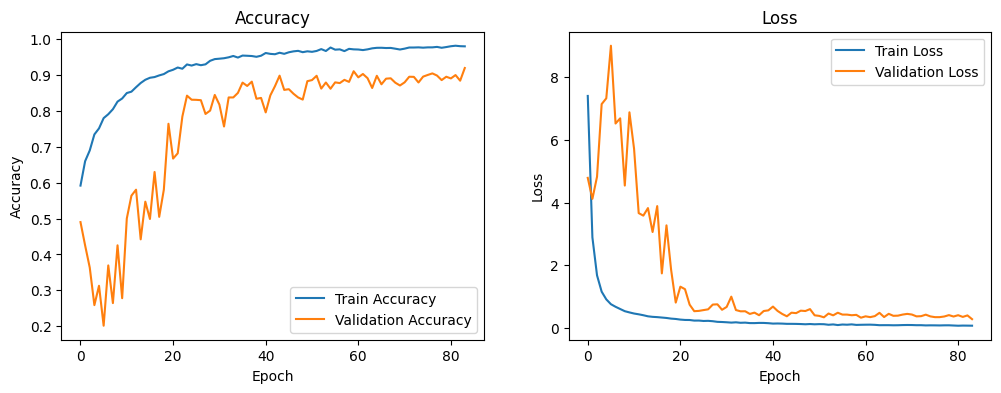

In [14]:
# Evaluasi model pada validation set
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Plot grafik akurasi dan loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

# Visualisasi history pelatihan
plot_history(history)

In [15]:
import tensorflow as tf
import numpy as np
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display

# Asumsikan model sudah dimuat, misalnya:
# model = tf.keras.models.load_model("your_diabetic_retinopathy_model.h5")

# Buat widget untuk upload file
uploader = widgets.FileUpload(accept="image/*", multiple=True)

# Buat output widget untuk menampilkan hasil
out = widgets.Output()

# Menampilkan widget upload dan output
display(uploader)
display(out)

def file_predict(filename, file, out):
    """ Fungsi untuk membuat prediksi dan mencetak hasilnya."""
    # Load dan preprocess gambar
    image = tf.keras.utils.load_img(file, target_size=(512, 512))  # Sesuaikan ukuran gambar sesuai model
    image = tf.keras.utils.img_to_array(image)
    image = image / 512.0  # Normalisasi pixel agar berada dalam rentang [0, 1]
    image = np.expand_dims(image, axis=0)

    # Prediksi model untuk tingkat diabetic retinopathy
    prediction = model.predict(image, verbose=0)[0]
    predicted_class = np.argmax(prediction)
    predicted_probability = prediction[predicted_class]

    with out:
        # Tampilkan hasil prediksi
        print(f"{filename} diprediksi dengan tingkat keparahan {predicted_class} dengan probabilitas {predicted_probability:.2f}")
        if predicted_class == 0:
            print("Tidak ada retinopati yang terdeteksi.")
        elif predicted_class == 1:
            print("Retinopati ringan terdeteksi.")
        elif predicted_class == 2:
            print("Retinopati sedang terdeteksi.")
        elif predicted_class == 3:
            print("Retinopati parah terdeteksi.")
        elif predicted_class == 4:
            print("Retinopati proliferatif terdeteksi.")

def on_upload_change(change):
    """ Fungsi untuk menangani perubahan pada upload dan menjalankan prediksi."""
    # Mengakses data yang diunggah
    uploaded_files = uploader.value
    for filename, file_info in uploaded_files.items():
        file_jpgdata = BytesIO(file_info["content"])  # Ambil konten file sebagai bytes
        file_predict(filename, file_jpgdata, out)  # Lakukan prediksi

# Tambahkan observer untuk mengamati perubahan pada widget
uploader.observe(on_upload_change, names='value')


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

In [19]:
model.save('my_model.keras')

In [20]:
saved_model_dir = "saved_model"
model.export(saved_model_dir)

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='keras_tensor_155')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float16, name=None)
Captures:
  133726289389248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726362578864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726282675328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726282713568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133728907960816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726362581856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726362474928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726362472112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726362576048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726362573232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133726362719104

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TFLite built-in ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TF Select ops
]
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_file = "model_with_flex_ops.tflite"
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model with flex ops saved as {tflite_model_file}")

TFLite model with flex ops saved as model_with_flex_ops.tflite


In [22]:
def zip_saved_model(saved_model_dir, zip_filename):
  """
  Zips the contents of a saved_model directory.

  Args:
    saved_model_dir: The path to the saved_model directory.
    zip_filename: The desired filename for the zip archive.
  """

  try:
    shutil.make_archive(zip_filename, 'zip', saved_model_dir)
    print(f"Saved model zipped successfully to {zip_filename}.zip")
  except Exception as e:
    print(f"Error zipping saved model: {e}")


# Example usage:
saved_model_dir = "saved_model"  # Replace with your saved model directory
zip_filename = "saved_model"  # Replace with your desired zip filename

zip_saved_model(saved_model_dir, zip_filename)

Saved model zipped successfully to saved_model.zip
